Concatenate all predictions 
Separate by tissue and extract 2k most variable genes
Filter to only contain predictions of the most variable genes
Save filtered by tissue and chromosome 

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import re
import ast
import os 
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set working directory
os.chdir("/pool01/projects/abante_lab/")

weighted_sed_path = "genomic_llms/borzoi/proc_results/weighted_logSED/"
fig_path = "genomic_llms/borzoi/proc_results/figures/"

putamen_path = f"{weighted_sed_path}putamen/"
caudate_path = f"{weighted_sed_path}caudate/"

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Read concatenated weighted preds
preds = pl.concat(
    [pl.read_csv(os.path.join(weighted_sed_path, f), separator = '\t') 
     for f in os.listdir(weighted_sed_path) if f.endswith(".tsv.gz")]
)
putamen_preds = preds.filter(preds["tissue"] == "RNA-seq: Putamen")
caudate_preds = preds.filter(preds["tissue"] == "RNA-seq: Caudate")

In [4]:
putamen_preds

snp,gene,alt_allele,tissue,logSED,chrom,pos,genehancer_id,weighted_logSED
str,str,str,str,f64,i64,i64,str,f64
"""21_33758366_C_G""","""ENSG00000170262""","""G""","""RNA-seq: Putamen""",-0.000042,21,32386057,"""GH21F032386""",-1.4165e-8
"""21_33758366_C_G""","""ENSG00000232623""","""G""","""RNA-seq: Putamen""",-0.000236,21,32386057,"""GH21F032386""",-7.9922e-8
"""21_33758366_C_G""","""ENSG00000142207""","""G""","""RNA-seq: Putamen""",-0.000137,21,32386057,"""GH21F032386""",-4.6384e-8
"""21_33758366_C_G""","""ENSG00000256073""","""G""","""RNA-seq: Putamen""",-0.000469,21,32386057,"""GH21F032386""",-1.5863e-7
"""21_33758366_C_G""","""ENSG00000166979""","""G""","""RNA-seq: Putamen""",0.0000748,21,32386057,"""GH21F032386""",2.5288e-8
…,…,…,…,…,…,…,…,…
"""22_23280836_G_A""","""ENSG00000254030""","""A""","""RNA-seq: Putamen""",0.0004568,22,22938670,"""GH22F022937""",2.4927e-20
"""22_23280836_G_A""","""ENSG00000211682""","""A""","""RNA-seq: Putamen""",0.0007625,22,22938670,"""GH22F022937""",4.1609e-20
"""22_23280836_G_A""","""ENSG00000222037""","""A""","""RNA-seq: Putamen""",0.001893,22,22938670,"""GH22F022937""",1.0330e-19


In [5]:
# Group by gene and calculate variability
putamen_variability = (
    putamen_preds
    .group_by("gene")
    .agg(pl.std("weighted_logSED").alias("std_dev"))
    .filter(pl.col("std_dev").is_not_null())
    .sort("std_dev", descending=True)
    .head(2000)
)
putamen_genes = set(putamen_variability["gene"].to_list())

caudate_variability = (
    caudate_preds
    .group_by("gene")
    .agg(pl.std("weighted_logSED").alias("std_dev"))
    .filter(pl.col("std_dev").is_not_null())
    .sort("std_dev", descending=True)
    .head(2000)
)
caudate_genes = set(caudate_variability["gene"].to_list())

In [6]:
# Filter preds to only contain the top 2000 variable genes
filtered_preds = preds.filter(pl.col("gene").is_in(putamen_genes | caudate_genes))
filtered_preds

snp,gene,alt_allele,tissue,logSED,chrom,pos,genehancer_id,weighted_logSED
str,str,str,str,f64,i64,i64,str,f64
"""21_36398684_T_C""","""ENSG00000159216""","""C""","""RNA-seq: Putamen""",0.00354,21,35026387,"""GH21F035024""",7.4067e-10
"""21_36398684_T_C""","""ENSG00000159216""","""C""","""RNA-seq: Caudate""",0.00475,21,35026387,"""GH21F035024""",9.9384e-10
"""21_27530760_C_T""","""ENSG00000273492""","""T""","""RNA-seq: Putamen""",-0.001067,21,26158442,"""GH21F026157""",-0.000001
"""21_27530760_C_T""","""ENSG00000273492""","""T""","""RNA-seq: Caudate""",-0.0057,21,26158442,"""GH21F026157""",-0.000008
"""21_36414027_T_C""","""ENSG00000159216""","""C""","""RNA-seq: Putamen""",0.001674,21,35041730,"""GH21F035038""",5.0696e-45
…,…,…,…,…,…,…,…,…
"""22_24146055_T_G""","""ENSG00000099953""","""G""","""RNA-seq: Caudate""",0.0000492,22,23803868,"""GH22F023799""",8.9908e-17
"""22_24094476_T_G""","""ENSG00000250479""","""G""","""RNA-seq: Putamen""",-0.002739,22,23752289,"""GH22F023749""",-0.000002
"""22_24094476_T_G""","""ENSG00000250479""","""G""","""RNA-seq: Caudate""",-0.00131,22,23752289,"""GH22F023749""",-0.000001


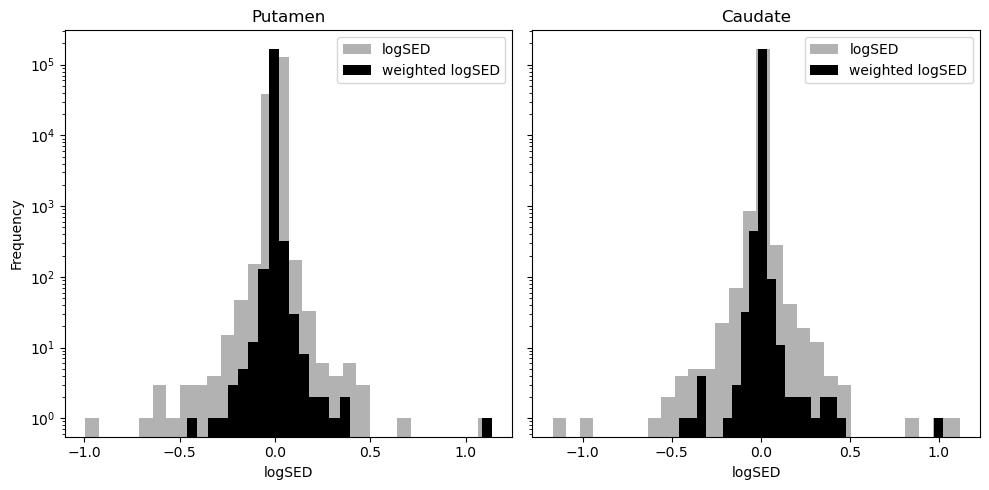

In [7]:
# Filter the dataframe
# Filter using Polars
preds1 = filtered_preds.filter(filtered_preds["tissue"] == "RNA-seq: Putamen")
preds2 = filtered_preds.filter(filtered_preds["tissue"] == "RNA-seq: Caudate")

# Convert to pandas for plotting
df1 = preds1.to_pandas()
df2 = preds2.to_pandas()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# RNA-seq: Putamen
axes[0].hist(df1["logSED"], bins=30, color='grey', alpha=0.6, label='logSED')
axes[0].hist(df1["weighted_logSED"], bins=30, color='black', label='weighted logSED')
axes[0].set_title("Putamen")
axes[0].set_xlabel('logSED')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].legend(loc='upper right')

# RNA-seq: Caudate
axes[1].hist(df2["logSED"], bins=30, color='grey', alpha=0.6, label='logSED')
axes[1].hist(df2["weighted_logSED"], bins=30, color='black', label='weighted logSED')
axes[1].set_title("Caudate")
axes[1].set_xlabel('logSED')
axes[1].set_yscale('log')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{fig_path}filtered_weighted_logSED.pdf", dpi=300)
plt.show()

In [8]:
# Save filtered preds by chromosome
for tissue, tissue_path in {"RNA-seq: Putamen": putamen_path, "RNA-seq: Caudate": caudate_path}.items():
    tissue_preds = filtered_preds.filter(pl.col("tissue") == tissue)
    for chrom in range(1,23):
        chrom_preds = tissue_preds.filter(pl.col("chrom") == chrom)
        chrom_preds.write_csv(f"{tissue_path}filtered_weighted_logSED_chr{chrom}.tsv", separator='\t')